## GA4 Traffic Breakdown & Cohort Analysis Report

### Introduction

This analysis examines user retention and lifetime value (LTV) for an e‑commerce site over the first three months of 2025. We’ve grouped users into monthly acquisition cohorts (Jan, Feb, Mar) and tracked:

* **Retention Rate**: % of users returning in subsequent months
* **Cumulative LTV**: Total revenue generated per cohort over time

The goal is to understand which acquisition periods deliver the most engaged and highest‑value customers, and to derive actionable strategies for optimizing future marketing spend and product experiences.

---

In [85]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from operator import attrgetter

sns.set(style='whitegrid')

In [86]:
# Cell 2: Load GA4 mock data
df = pd.read_csv(r"C:\Users\phuoc\ga4-traffic-breakdown\data\ga4_sample_data.csv")
df['date'] = pd.to_datetime(df['date'])

print(f"✅ Loaded {len(df):,} rows")
df.head()

✅ Loaded 55,010 rows


,session_id,user_id,date,session_source,medium,device_category,country,session_duration,event_name,conversion
0,sess_583b07c8d0,1,2025-01-21,zalo,cpc,desktop,Thailand,214.92,begin_checkout,0
1,sess_4e824e02b4,1,2025-01-17,tiktok,social,desktop,United States,172.54,purchase,1
2,sess_894fbfd0ea,1,2025-01-16,zalo,referral,tablet,Japan,282.56,purchase,1
3,sess_ec0364327d,1,2025-01-31,zalo,social,mobile,India,308.27,page_view,0
4,sess_e8a2e6957f,1,2025-02-09,youtube,email,desktop,Vietnam,1903.79,add_to_cart,0


In [87]:
# Cell 3: Basic inspection
print(df.dtypes)
print(df['event_name'].value_counts())
print(df['conversion'].value_counts())

# Check unique users and sessions
print("Unique users:", df['user_id'].nunique())
print("Unique sessions:", df['session_id'].nunique())

session_id                  object
user_id                      int64
date                datetime64[ns]
session_source              object
medium                      object
device_category             object
country                     object
session_duration           float64
event_name                  object
conversion                   int64
dtype: object
event_name
add_to_cart       11096
page_view         11065
purchase          11053
scroll            10921
begin_checkout    10875
Name: count, dtype: int64
conversion
0    43957
1    11053
Name: count, dtype: int64
Unique users: 10000
Unique sessions: 55010


In [88]:
# Cell 4: Assign cohort (first session date per user)
df['cohort_date'] = df.groupby('user_id')['date'].transform('min')
df['cohort_date'] = df['cohort_date'].dt.to_period('M')
df['event_month'] = df['date'].dt.to_period('M')

df[['user_id', 'date', 'cohort_date', 'event_month']].head()

,user_id,date,cohort_date,event_month
0,1,2025-01-21,2025-01,2025-01
1,1,2025-01-17,2025-01,2025-01
2,1,2025-01-16,2025-01,2025-01
3,1,2025-01-31,2025-01,2025-01
4,1,2025-02-09,2025-01,2025-02


In [89]:
# Cell 5: Retention Table (Monthly)
cohort_data = df.groupby(['cohort_date', 'event_month'])['user_id'].nunique().reset_index()
cohort_data['period_index'] = (cohort_data['event_month'] - cohort_data['cohort_date']).apply(attrgetter('n'))

retention = cohort_data.pivot_table(
    index='cohort_date',
    columns='period_index',
    values='user_id'
)

retention_pct = retention.divide(retention.iloc[:,0], axis=0).round(3) * 100
retention_pct.fillna(0, inplace=True)
retention_pct

period_index,0,1,2
cohort_date,,,
2025-01,100.0,64.3,18.1
2025-02,100.0,32.1,0.0


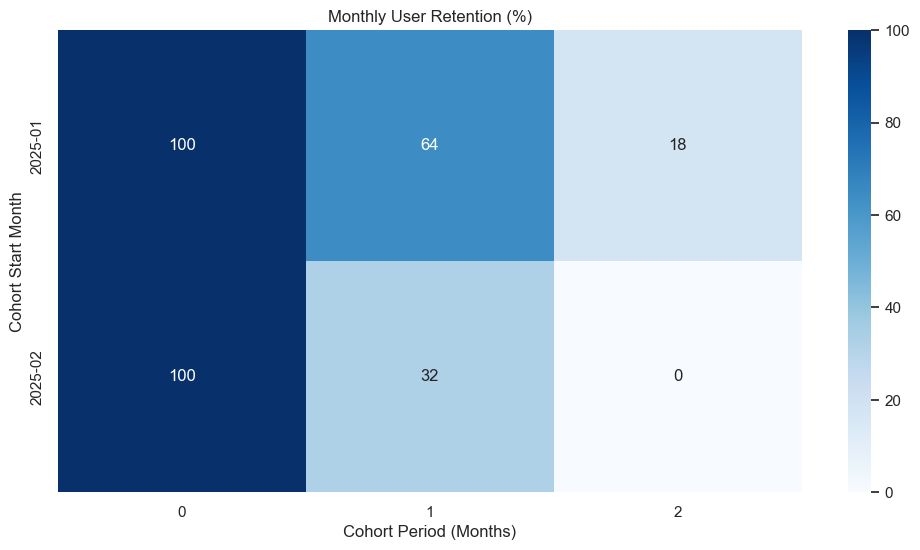

In [90]:
# Cell 6: Plot retention heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(retention_pct, annot=True, fmt='.0f', cmap='Blues')
plt.title('Monthly User Retention (%)')
plt.xlabel('Cohort Period (Months)')
plt.ylabel('Cohort Start Month')
plt.show()


In [91]:
# Cell 7: LTV by cohort (giả định mỗi chuyển đổi tạo $50)
ltv_data = df[df['conversion'] == 1].copy()
ltv_data['ltv'] = 50  # giả định revenue tĩnh

# Đảm bảo event_month và cohort_date tồn tại trong ltv_data
ltv_data['event_month'] = ltv_data['date'].dt.to_period('M')
ltv_data['cohort_date'] = ltv_data.groupby('user_id')['date'].transform('min').dt.to_period('M')

# Group và tính LTV theo cohort
ltv_by_cohort = ltv_data.groupby(['cohort_date', 'event_month'])['ltv'].sum().reset_index()
ltv_by_cohort['period_index'] = (ltv_by_cohort['event_month'] - ltv_by_cohort['cohort_date']).apply(attrgetter('n'))

# Pivot ra dạng bảng
ltv_pivot = ltv_by_cohort.pivot_table(
    index='cohort_date',
    columns='period_index',
    values='ltv'
)

# Tính cumulative LTV
ltv_cum = ltv_pivot.cumsum(axis=1).fillna(0)
ltv_cum.round(1)

period_index,0,1,2
cohort_date,,,
2025-01,325250.0,410050.0,422050.0
2025-02,113050.0,123750.0,0.0
2025-03,6850.0,0.0,0.0


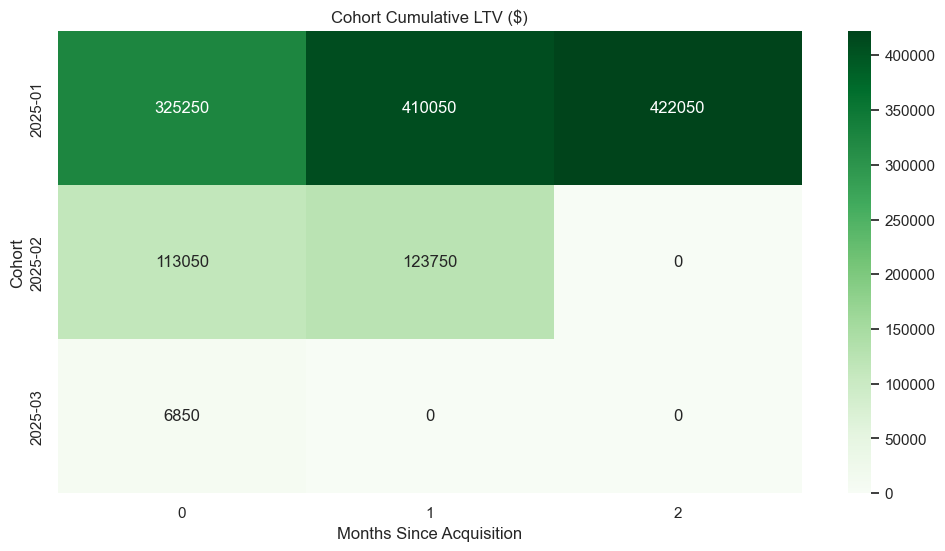

In [92]:
# Cell 8: Plot cumulative LTV
plt.figure(figsize=(12, 6))
sns.heatmap(ltv_cum, annot=True, fmt='.0f', cmap='Greens')
plt.title('Cohort Cumulative LTV ($)')
plt.xlabel('Months Since Acquisition')
plt.ylabel('Cohort')
plt.show()

## Key Insights

### Monthly User Retention (%)

* **January 2025 Cohort**:

  * **Month 1 retention**: 64% returned
  * **Month 2 retention**: 18% returned
* **February 2025 Cohort**:

  * **Month 1 retention**: 32% returned
  * **Month 2 retention**: 0% returned

> **Interpretation:**
>
> * January’s cohort shows strong mid‑term stickiness (over 60% Month 1), whereas February drops off more sharply.
> * By Month 2 only \~18% of January users remain active—indicating a second‑month churn risk.

### Cohort Cumulative LTV (\$)

* **January 2025 Cohort**:

  * \$325K by Month 0 → \$410K by Month 1 → \$422K by Month 2
* **February 2025 Cohort**:

  * \$113K → \$124K by Month 1 → \$0 in Month 2 (no return revenue)
* **March 2025 Cohort**:

  * \$6.8K initial → no subsequent revenue (insufficient time or engagement)

> **Interpretation:**
>
> * January cohort not only retains users but also sustains revenue growth into Month 2.
> * February cohort generates far less overall revenue and stops entirely after Month 1.
> * March is too recent to draw meaningful conclusions yet.

---

## Recommendations

| Finding                                                | Action                                                                                            |
| ------------------------------------------------------ | ------------------------------------------------------------------------------------------------- |
| January cohort outperforms in both retention & LTV     | Identify acquisition channels/campaigns from Jan; re‑allocate budget to similar sources           |
| Sharp drop‑off in Month 2 for all cohorts              | Implement targeted **re‑engagement campaigns** (email, push) around day 30 post‑signup            |
| February cohort under‑performs                         | Audit Feb promotions, landing pages, onboarding flows; A/B test improvements before re‑launch     |
| Very low early revenue in March cohort                 | Delay cohort judgment; set up **incentives** (e.g. first‑purchase discount) to boost early LTV    |
| Overall first‑month churn remains high (\~36–68% lost) | Enhance **onboarding experience**, in‑app tutorials, welcome flows to increase Month 1 stickiness |

By focusing on replicating January’s success drivers, plugging churn leakages in Month 2, and bolstering early revenue incentives, the product and marketing teams can improve both user retention and long‑term profitability.